# Identifying Student Favorite Activities

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

%matplotlib inline

## 1. Load Data

In [16]:
data_mahasiswa=pd.read_csv("../MHS.csv")
data_kegiatan=pd.read_csv("../SA.csv")


## 2. Data Preprocessing

In [17]:

def get_custom_stop_words():
    return set([
        # English stop words
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        # English words
        'ready', 'seminar', 'webinar', 'uib', 'local', 'national', 'international',
        'lokal', 'nasional', 'internasional', 'lgbt', 'series', 'club', 'meeting', 'conversation',
        'get', 'self', 'learning', 'skills', 'out', 'find', 'your', 'beginners', 'beginner', 'learn',
        'course', 'fundamentals', 'pengembangan', 'kepribadian', 'how', 'rules', 'about', 'collaboration',
        # Indonesian stop words
        'yang', 'di', 'ke', 'dari', 'dalam', 'pada', 'dengan', 'dan', 'atau',
        # Bahasa Indonesia words
        'ukm', 'merdeka', 'jam', 'belajar', 'sertifikasi', 'generasi', 
        # Conjunctions
        'namun', 'tetapi', 'akan', 'serta', 'karena', 'sebab',
        # Numbers and years (generic removal)
        '2020', '2021', '2022', '2023', '2024',
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        # Additional filtering
    ])

def fit_tfidf_model(activities, student_ids, stop_words=None):
    """
    Fit TF-IDF model to activities and create student profiles
    
    Parameters:
    - activities: list or Series of activity names
    - student_ids: corresponding list or Series of student IDs
    - stop_words: optional custom stop words
    
    Returns:
    - Dictionary containing model components
    """
    # Use custom stop words if provided, otherwise use default
    if stop_words is None:
        stop_words = get_custom_stop_words()
    
    # Create TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words=list(stop_words))
    
    # Transform activities
    tfidf_matrix = tfidf.fit_transform(activities)
    
    # Get feature names (keywords)
    keywords = tfidf.get_feature_names_out()
    
    # Create DataFrame of activity keywords
    activity_keywords = pd.DataFrame(
        tfidf_matrix.toarray(), 
        columns=keywords, 
        index=student_ids
    )
    
    # Aggregate keyword importance for each student
    student_profiles = activity_keywords.groupby(activity_keywords.index).sum()
    
    return {
        'tfidf': tfidf,
        'tfidf_matrix': tfidf_matrix,
        'keywords': keywords,
        'student_profiles': student_profiles
    }

def recommend_keywords(student_id, student_profiles, top_n=5):
    """
    Recommend top keywords for a given student
    
    Parameters:
    - student_id: ID of the student
    - student_profiles: DataFrame of student keyword profiles
    - keywords: list of keywords
    - top_n: number of top keywords to return
    
    Returns:
    - Series of top keywords and their importance
    """
    if student_id not in student_profiles.index:
        raise KeyError(f"Student ID {student_id} not found.")
    
    # Sort keywords by importance for the student
    student_keywords = student_profiles.loc[student_id].sort_values(ascending=False)
    
    # Return top N keywords
    return student_keywords.head(top_n)

def visualize_student_keywords(student_id, student_profiles, keywords, top_n=5):
    """
    Create a bar plot of top keywords for a student
    
    Parameters:
    - student_id: ID of the student
    - student_profiles: DataFrame of student keyword profiles
    - keywords: list of keywords
    - top_n: number of top keywords to visualize
    """
    # Get top keywords
    # top_keywords = recommend_keywords(student_id, student_profiles, keywords, top_n)
    top_keywords = recommend_keywords(student_id, student_profiles, top_n)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    top_keywords.plot(kind='bar')
    plt.title(f'Top {top_n} Keywords for Student {student_id}')
    plt.xlabel('Keywords')
    plt.ylabel('TF-IDF Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def save_model(model_components, filepath='student_activity_recommender.joblib'):
    """
    Save model components to a file
    
    Parameters:
    - model_components: Dictionary of model components
    - filepath: path to save the model
    """
    dump(model_components, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath='student_activity_recommender.joblib'):
    """
    Load previously saved model components
    
    Parameters:
    - filepath: path to the saved model file
    
    Returns:
    - Loaded model components
    """
    model_components = load(filepath)
    print(f"Model loaded from {filepath}")
    return model_components

# Example usage function for Jupyter Notebook
def quick_start(data_kegiatan):
    """
    Quick start function for Jupyter Notebook
    
    Parameters:
    - data_kegiatan: DataFrame with 'nama_kegiatan' and 'npm' columns
    
    Returns:
    - Dictionary of model components
    """
    # Fit the model
    model_components = fit_tfidf_model(
        data_kegiatan['nama_kegiatan'], 
        data_kegiatan['npm']
    )
    
    # Print basic information
    print("Model Fitted Successfully!")
    print(f"Total Number of Students: {len(model_components['student_profiles'])}")
    print(f"Total Number of Unique Keywords: {len(model_components['keywords'])}")
    
    # Example recommendations
    sample_students = model_components['student_profiles'].index[:5]
    print("\nSample Student Recommendations:")
    for student_id in sample_students:
        print(f"\nStudent {student_id}:")
        print(recommend_keywords(
            student_id, 
            model_components['student_profiles'], 
            # model_components['keywords']
        ))
    
    return model_components

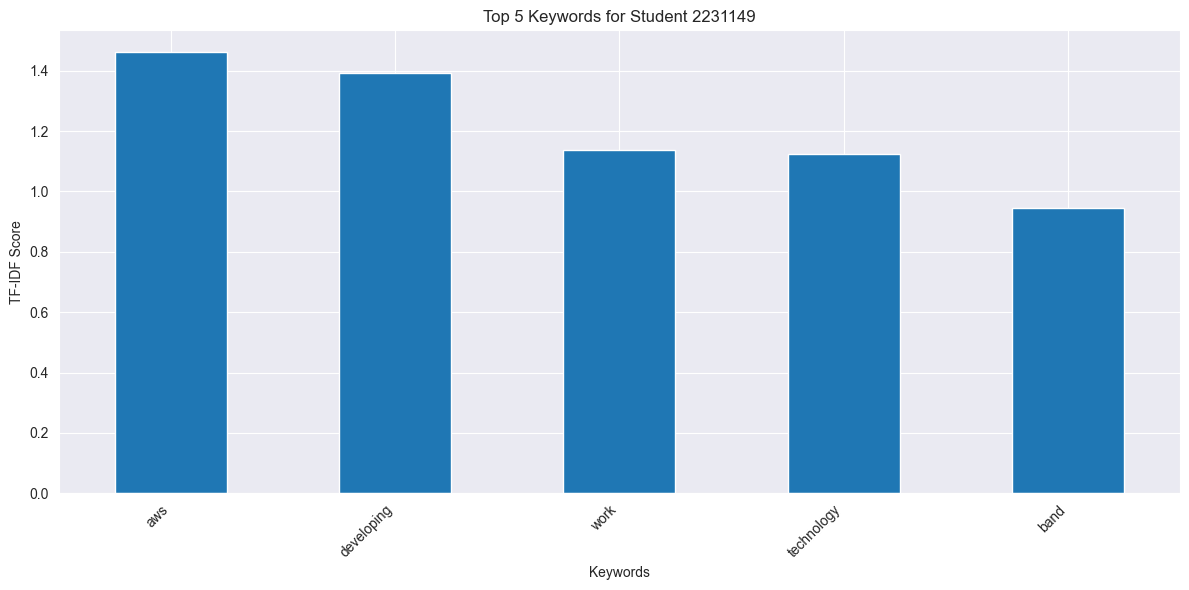

Model saved to student_activity_recommender.joblib
Model loaded from student_activity_recommender.joblib


In [23]:
# Fit the model
model_components = fit_tfidf_model(data_kegiatan['nama_kegiatan'], data_kegiatan['npm'])

# Get student profiles and keywords
student_profiles = model_components['student_profiles']
keywords = model_components['keywords']

# Recommend keywords for a specific student
student_id = 2231149
# recommended_keywords = recommend_keywords(student_id, student_profiles, keywords)
recommended_keywords = recommend_keywords(student_id, student_profiles)

# Visualize keywords
visualize_student_keywords(student_id, student_profiles, keywords)

# Save the model
save_model(model_components)

# Load the model in another session
loaded_model_components = load_model()

